In [19]:
import pandas as pd 
import matplotlib.pyplot as plt 

In [20]:
base_path = "/Users/dzz1th/Job/mgi/Soroka/data/pc_data/"
employment_levels_path = base_path + "employment_level_pairwise_scores.csv"
employment_dynamics_path = base_path + "employment_dynamics_pairwise_scores.csv"
inflation_levels_path = base_path + "inflation_level_pairwise_scores.csv"
inflation_dynamics_path = base_path + "inflation_dynamics_pairwise_scores.csv"
interest_rate_path = base_path + "interest_rate_trajectory_pairwise_scores.csv"
balance_sheet_path = base_path + "balance_sheet_trajectory_pairwise_scores.csv"
guidance_path = base_path + "forward_guidance_guidance_pairwise_scores.csv"


employment_levels_df = pd.read_csv(employment_levels_path)
employment_dynamics_df = pd.read_csv(employment_dynamics_path)
inflation_levels_df = pd.read_csv(inflation_levels_path)
inflation_dynamics_df = pd.read_csv(inflation_dynamics_path)
interest_rate_df = pd.read_csv(interest_rate_path)
balance_sheet_df = pd.read_csv(balance_sheet_path)
guidance_df = pd.read_csv(guidance_path)

In [21]:
from functools import reduce

employment_levels_df = employment_levels_df[['date', 'employment_level_score']]
employment_dynamics_df = employment_dynamics_df[['date', 'employment_dynamics_score']]
inflation_levels_df = inflation_levels_df[['date', 'inflation_level_score']]
inflation_dynamics_df = inflation_dynamics_df[['date', 'inflation_dynamics_score']]
interest_rate_df = interest_rate_df[['date', 'interest_rate_trajectory_score']]
balance_sheet_df = balance_sheet_df[['date', 'balance_sheet_trajectory_score']]
guidance_df = guidance_df[['date', 'forward_guidance_guidance_score']]

# Create a single dataframe with all score columns
df = pd.DataFrame({
    'date': employment_levels_df['date'],
    'employment_level_score': employment_levels_df['employment_level_score'],
    'employment_dynamics_score': employment_dynamics_df['employment_dynamics_score'],
    'inflation_level_score': inflation_levels_df['inflation_level_score'],
    'inflation_dynamics_score': inflation_dynamics_df['inflation_dynamics_score'],
    'interest_rate_trajectory_score': interest_rate_df['interest_rate_trajectory_score'],
    'balance_sheet_trajectory_score': balance_sheet_df['balance_sheet_trajectory_score'],
    'forward_guidance_guidance_score': guidance_df['forward_guidance_guidance_score']
})


df['date'] = pd.to_datetime(df['date'])

In [22]:
### Some magic regarding fixing the inflation scores

## Invert Employment Level Scores
df['employment_level_score'] = -1 * df['employment_level_score']

## Invert Employment Dynamics Scores
df['employment_dynamics_score'] = -1 * df['employment_dynamics_score']

## Invert Inflation Level Scores since 2020-03-15
df['inflation_level_score'] = -1 * df['inflation_level_score']
#df.loc[df['date'] >= '2020-03-15', 'inflation_level_score'] = -df.loc[df['date'] >= '2020-03-15', 'inflation_level_score']

## Invert Inflation Dynamics Scores since 2020-03-15
df['inflation_dynamics_score'] = -1 * df['inflation_dynamics_score']
#df.loc[df['date'] >= '2020-03-15', 'inflation_dynamics_score'] = -df.loc[df['date'] >= '2020-03-15', 'inflation_dynamics_score']

## Invert Balance Sheet Scores completely
df['balance_sheet_trajectory_score'] = -1 * df['balance_sheet_trajectory_score']

In [23]:
df.to_csv('current_scores.csv')

In [24]:
base_cols = ['employment_level', 'employment_dynamics',	'inflation_level', 'inflation_dynamics', 'interest_rate_trajectory', 'balance_sheet_trajectory', 'forward_guidance_guidance']


max_lags = 3

### Create ordinary diffs
for col in base_cols:
    for lag in range(1, max_lags + 1):
        df[f'{col}_ord_diff_{lag}'] = df[f'{col}_score'].diff(lag)


### Create pct_diffs 
for col in base_cols:
    for lag in range(1, max_lags+1):
        df[f'{col}_pct_diff_{lag}'] = df[f'{col}_score'].pct_change(periods=lag)


## Compute diff * level_t-1
for col in base_cols:
    for lag in range(1, max_lags + 1):
        df[f'{col}_diff_mult_level_{lag}'] = df[f'{col}_score'].diff(lag) * df[f'{col}_score'].shift(lag)

## Compute cross differences (diff level * diff dynamics)
for lag in range(1, max_lags+1):
    df[f'employment_cross_diff'] = df[f'employment_level_score'].diff(lag) * df[f'employment_dynamics_score'].diff(lag)
    df['inflation_cross_diff'] = df[f'inflation_level_score'].diff(lag) * df[f'inflation_dynamics_score'].diff(lag)

/var/folders/bg/7dlg6wfn7l1cn6q3xxnwfj_80000gn/T/ipykernel_89137/889955710.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_pct_diff_{lag}'] = df[f'{col}_score'].pct_change(periods=lag)
/var/folders/bg/7dlg6wfn7l1cn6q3xxnwfj_80000gn/T/ipykernel_89137/889955710.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_pct_diff_{lag}'] = df[f'{col}_score'].pct_change(periods=lag)
/var/folders/bg/7dlg6wfn7l1cn6q3xxnwfj_80000gn/T/ipykernel_89137/889955710.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future versio

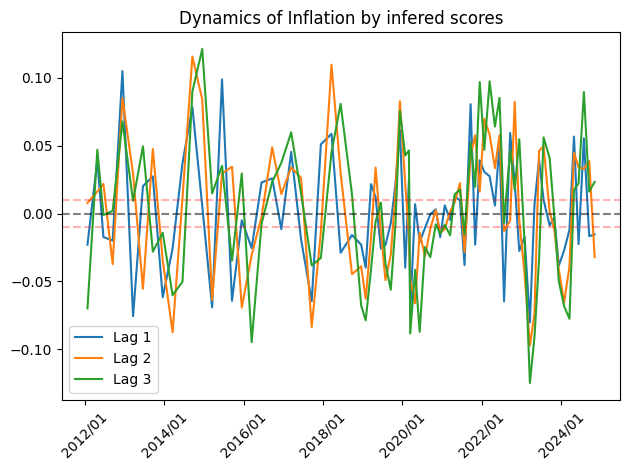

In [25]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np

def sigmoid(x):
    return 1/ (1 + np.exp(-x))

margin = 0.01
start_interval = '2012-01-01'
end_interval = '2025-01-01'

plot_df = df[(df['date'] >= start_interval) & (df['date'] <= end_interval)]

base_col = 'interest_rate_trajectory_ord_diff'

plt.plot(plot_df['date'], plot_df[base_col + '_1'])
plt.plot(plot_df['date'], plot_df[base_col + '_2'])
plt.plot(plot_df['date'], plot_df[base_col + '_3'])
plt.title('Dynamics of Inflation by infered scores')
# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))  # Format as YYYY
plt.xticks(rotation=45)  # Rotate labels for better readability

# Add horizontal lines
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero line')
plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.3, label='Upper bound')
plt.axhline(y=-0.01, color='red', linestyle='--', alpha=0.3, label='Lower bound')

plt.legend(['Lag 1', 'Lag 2', 'Lag 3'])

plt.tight_layout()
plt.show()




In [26]:
df[['inflation_level_score', 'inflation_dynamics_score', 'employment_level_score', 'employment_dynamics_score', 'interest_rate_trajectory_score', 'balance_sheet_trajectory_score', 'forward_guidance_guidance_score']].corr()

,inflation_level_score,inflation_dynamics_score,employment_level_score,employment_dynamics_score,interest_rate_trajectory_score,balance_sheet_trajectory_score,forward_guidance_guidance_score
inflation_level_score,1.000000,0.617589,0.077452,0.165698,0.413475,-0.488797,-0.084240
inflation_dynamics_score,0.617589,1.000000,0.103163,0.209221,0.502452,-0.478671,-0.130290
employment_level_score,0.077452,0.103163,1.000000,0.886940,0.308719,-0.283335,-0.376620
employment_dynamics_score,0.165698,0.209221,0.886940,1.000000,0.391699,-0.400352,-0.358816
interest_rate_trajectory_score,0.413475,0.502452,0.308719,0.391699,1.000000,-0.581336,-0.275192
balance_sheet_trajectory_score,-0.488797,-0.478671,-0.283335,-0.400352,-0.581336,1.000000,0.243880
forward_guidance_guidance_score,-0.084240,-0.130290,-0.376620,-0.358816,-0.275192,0.243880,1.000000


In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

start_interval = '2012-01-01'
end_interval = '2025-01-01'

plot_df = df[(df['date'] >= start_interval) & (df['date'] <= end_interval)]

# Create subplots with one column
fig = make_subplots(
    rows=len(base_cols), 
    cols=1,
    vertical_spacing=0.05,
    shared_xaxes=False,
    subplot_titles=[col.replace('_', ' ').title() for col in base_cols]  # Add titles above
)

# Add traces for each score in separate subplots
for idx, col in enumerate(base_cols):
    col_name = col + '_score'
    
    fig.add_trace(
        go.Scatter(
            x=plot_df['date'],
            y=plot_df[col_name],
            name=col.replace('_', ' ').title(),
            mode='lines',
            hovertemplate=
            '<b>Date</b>: %{x|%Y-%m-%d}<br>' +
            '<b>Score</b>: %{y:.3f}<br>'
        ),
        row=idx+1,
        col=1
    )

# Update layout
fig.update_layout(
    title={
        'text': 'Evolution of Different Scores Over Time',
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    height=170 * len(base_cols),
    width=1000,
    showlegend=False,
    margin=dict(t=100, b=20, l=50, r=50),
)

# Update subplot titles to be closer to their plots
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].update(y=fig.layout.annotations[i].y - 0.03)

# Add range selector buttons to all subplots
for i in range(1, len(base_cols) + 1):
    # Update x-axes
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label="6M", step="month", stepmode="backward"),
                dict(count=1, label="1Y", step="year", stepmode="backward"),
                dict(count=2, label="2Y", step="year", stepmode="backward"),
                dict(count=5, label="5Y", step="year", stepmode="backward"),
                dict(step="all", label="All")
            ]),
            font=dict(size=8),
            y=1.1,
        ),
        row=i, 
        col=1,
        showgrid=True, 
        gridwidth=1, 
        gridcolor='LightGray',
        dtick="M6",
        tickformat="%Y-%m"
    )
    
    # Update y-axes
    fig.update_yaxes(
        title_text="Score",
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray',
        row=i,
        col=1
    )

# Save the figure as an HTML file
output_path = 'scores_visualization.html'
pio.write_html(fig, file=output_path, auto_open=True)

print(f"Visualization has been saved to {output_path}")

Visualization has been saved to scores_visualization.html


In [13]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Convert date to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# Filter data for our time range (2019-01 to 2024-01)
mask = (df['date'] >= '2011-01-01') & (df['date'] <= '2025-01-31')
filtered_df = df.loc[mask].copy()

# Make sure the data is sorted by date
filtered_df = filtered_df.sort_values('date')

# Key events with dates and descriptions
key_events = [
    {'date': '2020-04-29', 'description': 'FED acknowledges significant drop in employment', 'color': 'red'},
    {'date': '2021-01-27', 'description': 'FED acknowledges recovery begins', 'color': 'green'},
    {'date': '2022-05-04', 'description': 'Peak labor market tightness', 'color': 'purple'},
    {'date': '2022-07-27', 'description': 'FED: "We need to see the labor market cool"', 'color': 'orange'},
    {'date': '2023-11-01', 'description': 'FED: "Balanced, non overheated"', 'color': 'blue'}
]

# Create the plot
fig = go.Figure()

# Add a simple line with markers
fig.add_trace(
    go.Scatter(
        x=filtered_df['date'], 
        y=filtered_df['employment_level_score'],
        mode='lines+markers',
        name='Employment Level Score',
        line=dict(color='#3366CC', width=2.5),
        marker=dict(
            size=8,
            color='#3366CC',
            line=dict(color='white', width=1)
        )
    )
)

# Add reference line at zero with clear styling
fig.add_shape(
    type="line",
    x0=filtered_df['date'].min(),
    y0=0,
    x1=filtered_df['date'].max(),
    y1=0,
    line=dict(color="black", width=1, dash="dash"),
)

# Add key events as vertical lines with clearly visible annotations
for event in key_events:
    event_date = pd.Timestamp(event['date'])
    
    # Find the nearest date in our data
    nearest_idx = abs(filtered_df['date'] - event_date).argmin()
    
    # Find the employment score on that date
    y_position = filtered_df.iloc[nearest_idx]['employment_level_score']
    
    # Add vertical line
    fig.add_shape(
        type="line",
        x0=event_date,
        y0=filtered_df['employment_level_score'].min() - 0.05,
        x1=event_date,
        y1=filtered_df['employment_level_score'].max() + 0.05,
        line=dict(
            color=event['color'],
            width=1.5,
            dash="solid",
        ),
    )
    
    # Add text labels directly on the chart for key events
    # Position the annotations strategically so they don't overlap
    position_adjustments = {
        '2020-04-29': {'x_offset': 0, 'y_offset': 0.08},
        '2021-01-27': {'x_offset': 0, 'y_offset': -0.1},
        '2022-05-04': {'x_offset': 0, 'y_offset': 0.08},
        '2022-07-27': {'x_offset': 0, 'y_offset': -0.08},
        '2023-11-01': {'x_offset': 0, 'y_offset': 0.1}
    }
    
    adj = position_adjustments.get(event['date'], {'x_offset': 0, 'y_offset': 0})
    
    # Create short labels for static display
    short_labels = {
        '2020-04-29': 'COVID impact',
        '2021-01-27': 'Recovery begins',
        '2022-05-04': 'Peak tightness',
        '2022-07-27': 'Pivot in narrative',
        '2023-11-01': 'Balanced, non overheated'
    }
    
    # Add clear text labels
    fig.add_annotation(
        x=event_date,
        y=y_position + adj['y_offset'],
        text=short_labels.get(event['date'], event['description']),
        showarrow=False,
        font=dict(size=12, color=event['color'], family="Arial", weight="bold"),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor=event['color'],
        borderwidth=2,
        borderpad=3
    )

# Add recession shading for COVID period
fig.add_shape(
    type="rect",
    x0="2020-02-15", 
    x1="2020-07-15",
    y0=filtered_df['employment_level_score'].min() - 0.1,
    y1=filtered_df['employment_level_score'].max() + 0.1,
    fillcolor="rgba(128, 128, 128, 0.2)", 
    line=dict(width=0),
    layer="below"
)

# Add clear text label for COVID recession
fig.add_annotation(
    x=pd.Timestamp("2020-04-15"),
    y=filtered_df['employment_level_score'].max() + 0.1,
    text="COVID Recession",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    borderpad=3
)

# Update layout with clear, print-friendly styling
fig.update_layout(
    title={
        'text': 'Federal Reserve Employment Assessment (2019-2024)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family="Arial", color="black")
    },
    showlegend=False,  # No legend needed for static display
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    width=1000,
    margin=dict(l=80, r=60, t=100, b=80)
)

# Use update_xaxes and update_yaxes with print-friendly settings
fig.update_xaxes(
    title_text="FOMC Meeting Date",
    title_font=dict(size=16, family="Arial", color="black"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    dtick="M3",
    tickformat="%b\n%Y",
    tickfont=dict(size=12, family="Arial", color="black"),
    zeroline=False
)

fig.update_yaxes(
    title_text="Employment Level Score",
    title_font=dict(size=16, family="Arial", color="black"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    tickfont=dict(size=12, family="Arial", color="black")
)

# Add static text annotations explaining the scores
fig.add_annotation(
    x=pd.Timestamp("2019-06-15"),
    y=0.15,
    text="↑ Improving Employment",
    showarrow=False,
    font=dict(size=14, color="#3366CC"),
    align="left",
    bgcolor="white",
    bordercolor="#3366CC",
    borderwidth=1,
    borderpad=3
)

fig.add_annotation(
    x=pd.Timestamp("2019-06-15"),
    y=-0.15,
    text="↓ Deteriorating Employment",
    showarrow=False,
    font=dict(size=14, color="#3366CC"),
    align="left",
    bgcolor="white",
    bordercolor="#3366CC",
    borderwidth=1,
    borderpad=3
)

# Show the figure
fig.show()

# Save as a static image for presentations
fig.write_image("fed_employment_assessment_static.png", scale=2)  # Higher scale for better resolution

# Save as HTML just in case
fig.write_html("fed_employment_assessment_static.html")

In [19]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Convert date to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# Filter data for our time range (2019-01 to 2024-01)
mask = (df['date'] >= '2019-01-01') & (df['date'] <= '2025-01-31')
filtered_df = df.loc[mask].copy()

# Make sure the data is sorted by date
filtered_df = filtered_df.sort_values('date')

# Key events with dates and descriptions for inflation
key_events = [
    {'date': '2020-03-15', 'description': 'COVID Impact', 'color': 'red'},
    {'date': '2020-09-16', 'description': 'Transitory Inflation', 'color': 'orange'},
    {'date': '2022-07-27', 'description': 'Inflation Peak', 'color': 'purple'},
    {'date': '2024-01-31', 'description': 'Inflation Stabilization', 'color': 'green'}
]

# Create the figure
fig = go.Figure()

# Add inflation level score
fig.add_trace(
    go.Scatter(
        x=filtered_df['date'], 
        y=filtered_df['inflation_level_score'],
        mode='lines+markers',
        name='Inflation Level',
        line=dict(color='#1F77B4', width=2.5),  # Blue for inflation level
        marker=dict(
            size=8,
            color='#1F77B4',
            line=dict(color='white', width=1)
        )
    )
)

# Add reference line at zero
fig.add_shape(
    type="line",
    x0=filtered_df['date'].min(),
    y0=0,
    x1=filtered_df['date'].max(),
    y1=0,
    line=dict(color="black", width=1, dash="dash"),
)

# Add key events as vertical lines with clearly visible annotations
for event in key_events:
    event_date = pd.Timestamp(event['date'])
    
    # Find the nearest date in our data
    nearest_idx = abs(filtered_df['date'] - event_date).argmin()
    
    # Find the inflation score on that date (if available)
    y_position = 0
    if nearest_idx < len(filtered_df):
        y_position = filtered_df.iloc[nearest_idx]['inflation_level_score']
    
    # Add vertical line
    fig.add_shape(
        type="line",
        x0=event_date,
        y0=filtered_df['inflation_level_score'].min() - 0.1,
        x1=event_date,
        y1=filtered_df['inflation_level_score'].max() + 0.1,
        line=dict(
            color=event['color'],
            width=1.5,
            dash="solid",
        ),
    )
    
    # Position adjustments for annotations to prevent overlap and move out of middle
    # Vary the positions based on event date
    y_offsets = {
        '2020-03-15': 0.3,
        '2020-09-16': -0.3,
        '2022-07-27': 0.1,
        '2024-01-31': -0.1
    }
    
    y_offset = y_offsets.get(event['date'], 0)
    
    # Add clear text labels
    fig.add_annotation(
        x=event_date,
        y=y_position + y_offset,
        text=event['description'],
        showarrow=False,
        font=dict(size=12, color=event['color'], family="Arial", weight="bold"),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor=event['color'],
        borderwidth=2,
        borderpad=3,
    )

# Add recession shading for COVID period
fig.add_shape(
    type="rect",
    x0="2020-02-15", 
    x1="2020-07-15",
    y0=filtered_df['inflation_level_score'].min() - 0.2,
    y1=filtered_df['inflation_level_score'].max() + 0.2,
    fillcolor="rgba(128, 128, 128, 0.2)", 
    line=dict(width=0),
    layer="below",
)

# Add clear text label for COVID recession
fig.add_annotation(
    x=pd.Timestamp("2020-04-15"),
    y=filtered_df['inflation_level_score'].max() + 0.2,
    text="COVID Recession",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    borderpad=3,
)

# Add annotations for inflation level score - moved to edges
fig.add_annotation(
    x=pd.Timestamp("2019-03-01"),
    y=filtered_df['inflation_level_score'].max() * 0.8,
    text="↑ Rising Inflation",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

fig.add_annotation(
    x=pd.Timestamp("2019-03-01"),
    y=filtered_df['inflation_level_score'].min() * 0.8,
    text="↓ Falling Inflation",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

# Update layout with clear, print-friendly styling
fig.update_layout(
    title={
        'text': 'Federal Reserve Inflation Assessment (2019-2024)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family="Arial", color="black")
    },
    showlegend=False,  # No legend needed
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    width=1000,
    margin=dict(l=80, r=60, t=100, b=80)
)

# Update x-axis
fig.update_xaxes(
    title_text="FOMC Meeting Date",
    title_font=dict(size=16, family="Arial", color="black"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    dtick="M3",
    tickformat="%b\n%Y",
    tickfont=dict(size=12, family="Arial", color="black"),
    zeroline=False
)

# Update y-axis
fig.update_yaxes(
    title_text="Inflation Level Score",
    title_font=dict(size=16, family="Arial", color="#1F77B4"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    tickfont=dict(size=12, family="Arial", color="#1F77B4"),
)

# Show the figure
fig.show()

# Save as a static image for presentations
fig.write_image("fed_inflation_level_assessment.png", scale=2)  # Higher scale for better resolution

# Save as HTML
fig.write_html("fed_inflation_level_assessment.html")

In [81]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Convert date to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# Filter data for our time range (2019-01 to 2024-03)
mask = (df['date'] >= '2018-03-01') & (df['date'] <= '2025-01-31')
filtered_df = df.loc[mask].copy()

# Make sure the data is sorted by date
filtered_df = filtered_df.sort_values('date')

# Key events with dates and descriptions for interest rate trajectory
key_events = [
    {'date': '2018-12-19', 'description': 'Trade War/Volatility', 'color': 'red'},
    {'date': '2019-12-11', 'description': '"Appropriate" Rate', 'color': 'orange'},
    {'date': '2022-11-02', 'description': 'Peak Rates', 'color': 'purple'},
    {'date': '2023-03-22', 'description': 'Hikes->Plateau', 'color': 'orange'},
    {'date': '2024-03-20', 'description': 'Cuts Later this Year', 'color': 'green'},
    {'date': '2024-09-18', 'description': 'First Cut', 'color': 'blue'}
]

# Create the figure
fig = go.Figure()

# Add interest rate trajectory score
fig.add_trace(
    go.Scatter(
        x=filtered_df['date'], 
        y=filtered_df['interest_rate_trajectory_score'],
        mode='lines+markers',
        name='Interest Rate Trajectory',
        line=dict(color='#1F77B4', width=2.5),  # Blue for interest rate trajectory
        marker=dict(
            size=8,
            color='#1F77B4',
            line=dict(color='white', width=1)
        )
    )
)

# Add reference line at zero
fig.add_shape(
    type="line",
    x0=filtered_df['date'].min(),
    y0=0,
    x1=filtered_df['date'].max(),
    y1=0,
    line=dict(color="black", width=1, dash="dash"),
)

# Add key events as vertical lines with clearly visible annotations
for event in key_events:
    event_date = pd.Timestamp(event['date'])
    
    # Find the nearest date in our data
    nearest_idx = abs(filtered_df['date'] - event_date).argmin()
    
    # Find the interest rate score on that date (if available)
    y_position = 0
    if nearest_idx < len(filtered_df):
        y_position = filtered_df.iloc[nearest_idx]['interest_rate_trajectory_score']
    
    # Add vertical line
    fig.add_shape(
        type="line",
        x0=event_date,
        y0=filtered_df['interest_rate_trajectory_score'].min() - 0.1,
        x1=event_date,
        y1=filtered_df['interest_rate_trajectory_score'].max() + 0.1,
        line=dict(
            color=event['color'],
            width=1.5,
            dash="solid",
        ),
    )
    
    # Position adjustments for annotations to prevent overlap
    y_offsets = {
        '2018-12-19': 0.2,
        '2019-12-11': 0.2,
        '2022-11-02': 0.2,
        '2023-03-22': -0.2,
        '2024-03-20': 0.2,
        '2024-09-18': -0.2
    }
    
    y_offset = y_offsets.get(event['date'], 0)
    
    # Add clear text labels
    fig.add_annotation(
        x=event_date,
        y=y_position + y_offset,
        text=event['description'],
        showarrow=False,
        font=dict(size=12, color=event['color'], family="Arial", weight="bold"),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor=event['color'],
        borderwidth=2,
        borderpad=3,
    )

# Add recession shading for COVID period
fig.add_shape(
    type="rect",
    x0="2020-02-15", 
    x1="2020-07-15",
    y0=filtered_df['interest_rate_trajectory_score'].min() - 0.2,
    y1=filtered_df['interest_rate_trajectory_score'].max() + 0.2,
    fillcolor="rgba(128, 128, 128, 0.2)", 
    line=dict(width=0),
    layer="below",
)

# Add clear text label for COVID recession
fig.add_annotation(
    x=pd.Timestamp("2020-04-15"),
    y=filtered_df['interest_rate_trajectory_score'].max() + 0.2,
    text="COVID Recession",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    borderpad=3,
)



# Add annotations for interest rate trajectory interpretations
fig.add_annotation(
    x=pd.Timestamp("2018-03-01"),
    y=filtered_df['interest_rate_trajectory_score'].max() * 1.5, 
    text="↑ Rising Rates",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

fig.add_annotation(
    x=pd.Timestamp("2018-03-01"),
    y=filtered_df['interest_rate_trajectory_score'].min() * 1.5,
    text="↓ Falling Rates",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

# Update layout with clear, print-friendly styling
fig.update_layout(
    title={
        'text': 'Federal Reserve Interest Rate Trajectory (2019-2024)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family="Arial", color="black")
    },
    showlegend=False,  # No legend needed
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    width=1000,
    margin=dict(l=80, r=60, t=100, b=80)
)

# Update x-axis
fig.update_xaxes(
    title_text="FOMC Meeting Date",
    title_font=dict(size=16, family="Arial", color="black"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    dtick="M3",
    tickformat="%b\n%Y",
    tickfont=dict(size=12, family="Arial", color="black"),
    zeroline=False
)

# Update y-axis
fig.update_yaxes(
    title_text="Interest Rate Trajectory Score",
    title_font=dict(size=16, family="Arial", color="#1F77B4"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    tickfont=dict(size=12, family="Arial", color="#1F77B4"),
)

# Show the figure
fig.show()

# Save as a static image for presentations
fig.write_image("fed_interest_rate_trajectory.png", scale=2)  # Higher scale for better resolution

# Save as HTML
fig.write_html("fed_interest_rate_trajectory.html")

In [46]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Convert date to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# Filter data starting from 2018
mask = (df['date'] >= '2018-01-01') & (df['date'] <= '2025-01-01')
filtered_df = df.loc[mask].copy()

# Make sure the data is sorted by date
filtered_df = filtered_df.sort_values('date')

# Key events with dates and descriptions for balance sheet trajectory
key_events = [
    {'date': '2019-10-30', 'description': 'Liquidity Injections', 'color': 'orange'},
    {'date': '2020-03-15', 'description': 'QE Announced', 'color': 'green'},
    {'date': '2022-03-16', 'description': 'QT Narrative', 'color': 'red'}
]

# Create the figure
fig = go.Figure()

# Add balance sheet trajectory score
fig.add_trace(
    go.Scatter(
        x=filtered_df['date'], 
        y=filtered_df['balance_sheet_trajectory_score'],
        mode='lines+markers',
        name='Balance Sheet Trajectory',
        line=dict(color='#1F77B4', width=2.5),  # Blue for balance sheet trajectory
        marker=dict(
            size=8,
            color='#1F77B4',
            line=dict(color='white', width=1)
        )
    )
)

# Add reference line at zero
fig.add_shape(
    type="line",
    x0=filtered_df['date'].min(),
    y0=0,
    x1=filtered_df['date'].max(),
    y1=0,
    line=dict(color="black", width=1, dash="dash"),
)

# Add key events as vertical lines with clearly visible annotations
for event in key_events:
    event_date = pd.Timestamp(event['date'])
    
    # Find the nearest date in our data
    nearest_idx = abs(filtered_df['date'] - event_date).argmin()
    
    # Find the balance sheet score on that date (if available)
    y_position = 0
    if nearest_idx < len(filtered_df):
        y_position = filtered_df.iloc[nearest_idx]['balance_sheet_trajectory_score']
    
    # Add vertical line
    fig.add_shape(
        type="line",
        x0=event_date,
        y0=filtered_df['balance_sheet_trajectory_score'].min() - 0.1,
        x1=event_date,
        y1=filtered_df['balance_sheet_trajectory_score'].max() + 0.1,
        line=dict(
            color=event['color'],
            width=1.5,
            dash="solid",
        ),
    )
    
    # Position adjustments for annotations to prevent overlap
    y_offsets = {
        '2019-10-30': 0.2,
        '2020-03-15': -0.2,
        '2022-03-16': 0.2
    }
    
    y_offset = y_offsets.get(event['date'], 0)
    
    # Add clear text labels
    fig.add_annotation(
        x=event_date,
        y=y_position + y_offset,
        text=event['description'],
        showarrow=False,
        font=dict(size=12, color=event['color'], family="Arial", weight="bold"),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor=event['color'],
        borderwidth=2,
        borderpad=3,
    )

# Add recession shading for COVID period
fig.add_shape(
    type="rect",
    x0="2020-02-15", 
    x1="2020-07-15",
    y0=filtered_df['balance_sheet_trajectory_score'].min() - 0.2,
    y1=filtered_df['balance_sheet_trajectory_score'].max() + 0.2,
    fillcolor="rgba(128, 128, 128, 0.2)", 
    line=dict(width=0),
    layer="below",
)

# Add clear text label for COVID recession
fig.add_annotation(
    x=pd.Timestamp("2020-04-15"),
    y=filtered_df['balance_sheet_trajectory_score'].max() + 0.2,
    text="COVID Recession",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    borderpad=3,
)

# Add annotations for balance sheet trajectory interpretations - moved to earlier date to avoid overlap
fig.add_annotation(
    x=pd.Timestamp("2018-06-01"),  # Earlier date to avoid overlap
    y=filtered_df['balance_sheet_trajectory_score'].max() * 0.8,
    text="↑ Accommodative",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

fig.add_annotation(
    x=pd.Timestamp("2018-06-01"),  # Earlier date to avoid overlap
    y=filtered_df['balance_sheet_trajectory_score'].min() * 0.8,
    text="↓ Tightening",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

# Update layout with clear, print-friendly styling
fig.update_layout(
    title={
        'text': 'Federal Reserve Balance Sheet Trajectory (2018-2024)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family="Arial", color="black")
    },
    showlegend=False,  # No legend needed
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    width=1000,
    margin=dict(l=80, r=60, t=100, b=80)
)

# Update x-axis
fig.update_xaxes(
    title_text="FOMC Meeting Date",
    title_font=dict(size=16, family="Arial", color="black"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    dtick="M6",  # Increased to 6-month intervals due to longer time range
    tickformat="%b\n%Y",
    tickfont=dict(size=12, family="Arial", color="black"),
    zeroline=False
)

# Update y-axis
fig.update_yaxes(
    title_text="Balance Sheet Trajectory Score",
    title_font=dict(size=16, family="Arial", color="#1F77B4"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    tickfont=dict(size=12, family="Arial", color="#1F77B4"),
)

# Show the figure
fig.show()

# Save as a static image for presentations
fig.write_image("fed_balance_sheet_trajectory.png", scale=2)  # Higher scale for better resolution

# Save as HTML
fig.write_html("fed_balance_sheet_trajectory.html")

In [47]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Convert date to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# Filter data starting from January 2020
mask = (df['date'] >= '2020-01-01') & (df['date'] <= '2025-01-01')
filtered_df = df.loc[mask].copy()

# Make sure the data is sorted by date
filtered_df = filtered_df.sort_values('date')

# Key events with dates and descriptions for forward guidance
key_events = [
    {'date': '2021-11-03', 'description': 'Clear Tapering Plan', 'color': 'green'},
    {'date': '2022-06-15', 'description': 'Rate Hike for ?', 'color': 'orange'}
]

# Create the figure
fig = go.Figure()

# Add forward guidance score
fig.add_trace(
    go.Scatter(
        x=filtered_df['date'], 
        y=filtered_df['forward_guidance_guidance_score'],
        mode='lines+markers',
        name='Forward Guidance',
        line=dict(color='#1F77B4', width=2.5),  # Blue for forward guidance
        marker=dict(
            size=8,
            color='#1F77B4',
            line=dict(color='white', width=1)
        )
    )
)

# Add reference line at zero
fig.add_shape(
    type="line",
    x0=filtered_df['date'].min(),
    y0=0,
    x1=filtered_df['date'].max(),
    y1=0,
    line=dict(color="black", width=1, dash="dash"),
)

# Add key events as vertical lines with clearly visible annotations
for event in key_events:
    event_date = pd.Timestamp(event['date'])
    
    # Find the nearest date in our data
    nearest_idx = abs(filtered_df['date'] - event_date).argmin()
    
    # Find the forward guidance score on that date (if available)
    y_position = 0
    if nearest_idx < len(filtered_df):
        y_position = filtered_df.iloc[nearest_idx]['forward_guidance_guidance_score']
    
    # Add vertical line
    fig.add_shape(
        type="line",
        x0=event_date,
        y0=filtered_df['forward_guidance_guidance_score'].min() - 0.1,
        x1=event_date,
        y1=filtered_df['forward_guidance_guidance_score'].max() + 0.1,
        line=dict(
            color=event['color'],
            width=1.5,
            dash="solid",
        ),
    )
    
    # Position adjustments for annotations to prevent overlap
    y_offsets = {
        '2021-11-03': 0.1,
        '2022-06-15': -0.1
    }
    
    y_offset = y_offsets.get(event['date'], 0)
    
    # Add clear text labels
    fig.add_annotation(
        x=event_date,
        y=y_position + y_offset,
        text=event['description'],
        showarrow=False,
        font=dict(size=12, color=event['color'], family="Arial", weight="bold"),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor=event['color'],
        borderwidth=2,
        borderpad=3,
    )

# Add annotations for forward guidance score interpretations
fig.add_annotation(
    x=pd.Timestamp("2020-03-01"),
    y=filtered_df['forward_guidance_guidance_score'].max() * 0.8,
    text="↑ Stronger Forward Guidance",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

fig.add_annotation(
    x=pd.Timestamp("2020-03-01"),
    y=filtered_df['forward_guidance_guidance_score'].min() * 0.8,
    text="↓ Weaker Forward Guidance",
    showarrow=False,
    font=dict(size=14, color="#1F77B4"),
    align="left",
    bgcolor="white",
    bordercolor="#1F77B4",
    borderwidth=1,
    borderpad=3,
)

# Update layout with clear, print-friendly styling
fig.update_layout(
    title={
        'text': 'Federal Reserve Forward Guidance (2020-2024)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family="Arial", color="black")
    },
    showlegend=False,  # No legend needed
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    width=1000,
    margin=dict(l=80, r=60, t=100, b=80)
)

# Update x-axis
fig.update_xaxes(
    title_text="FOMC Meeting Date",
    title_font=dict(size=16, family="Arial", color="black"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    dtick="M3",
    tickformat="%b\n%Y",
    tickfont=dict(size=12, family="Arial", color="black"),
    zeroline=False
)

# Update y-axis
fig.update_yaxes(
    title_text="Forward Guidance Score",
    title_font=dict(size=16, family="Arial", color="#1F77B4"),
    showgrid=True,
    gridcolor='lightgray',
    gridwidth=1,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    tickfont=dict(size=12, family="Arial", color="#1F77B4"),
)

# Show the figure
fig.show()

# Save as a static image for presentations
fig.write_image("fed_forward_guidance.png", scale=2)  # Higher scale for better resolution

# Save as HTML
fig.write_html("fed_forward_guidance.html")

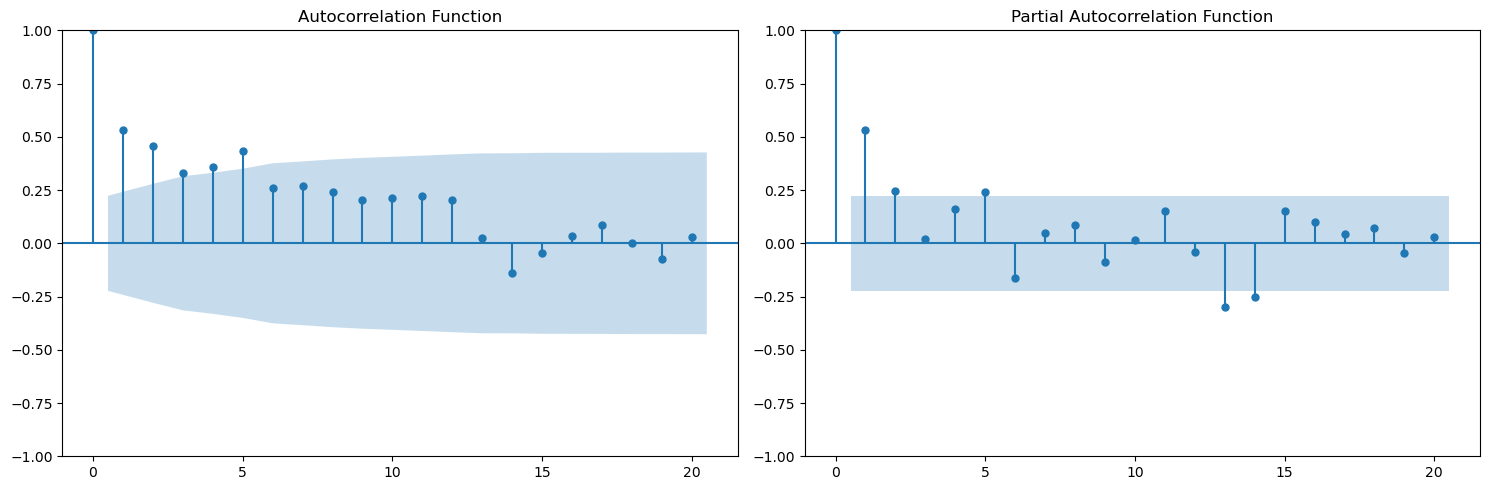

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


col = 'inflation_level_score'
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(plot_df[col].dropna(), 
         lags=20,
         alpha=0.05,  # 95% confidence interval
         title='Autocorrelation Function',
         ax=ax1)

# Plot PACF
plot_pacf(plot_df[col].dropna(), 
          lags=20,
          alpha=0.05,  # 95% confidence interval
          title='Partial Autocorrelation Function',
          ax=ax2)

plt.tight_layout()
plt.show()


We gonna estimate path of the interest rates on the differenced scores.
effect on different rates at different times (from 1d, 3d, 5d, 10d, 20d, 30d)

We also want to see whether there is a autocorrelation in the differences in scores. 

In [57]:
rates_path = "/Users/dzz1th/Job/mgi/Soroka/data/pc_data/us_yields.csv"
rates_df = pd.read_csv(rates_path, index_col=0)
rates_df.index = pd.to_datetime(rates_df.index)
rates_df.columns = ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '30Y']

for term in rates_df.columns:
    for d in [1, 3, 5, 10, 20, 30]:
        rates_df[f'{term}_{d}d'] = rates_df[term].shift(-d) - rates_df[term]

excel_file = "DataForOlehV2.xlsx"
long_history = pd.read_excel(
    excel_file,
    sheet_name="Long History", # 0-based index
    nrows=442
)

long_history.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
long_history['date'] = pd.to_datetime(long_history['date'])

long_history.head()
df0 = long_history[long_history['Meeting Date'] == 0]
df1 = long_history[long_history['Meeting Date'] == 1]

df1['date'] = df1['date'] - pd.Timedelta(days=1)
df1.columns = [f'{col}_1d' if col not in ['Meeting Date', 'date'] else col for col in df1.columns]
result_df = pd.merge(df0, df1, on='date', how='inner')

result_df


/var/folders/bg/7dlg6wfn7l1cn6q3xxnwfj_80000gn/T/ipykernel_90147/2728664674.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,Meeting Date_x,1y,2y,5y,7y,10y,30y,1y1y,2y1y,...,2s5s_1d,1y2s5s_1d,5s10s_1d,1y5s10s_1d,10s30s_1d,2y1y/3y2y_1d,3y2y/5y2y_1d,5y2y/7y3y_1d,5y5y/10y10y_1d,10y10y/20y10y_1d
0,2007-01-31,0,5.2489,5.1481,5.0977,5.1647,5.1929,4.0418,5.0553,5.0253,...,-0.0236,0.0514,0.0561,-0.0159,-1.1588,0.1177,0.1203,0.0986,-1.8997,-0.9001
1,2007-03-21,0,4.8911,4.7240,4.7649,4.8295,4.9030,3.8442,4.5469,4.6041,...,0.0322,0.2037,0.1388,0.0733,-1.0741,0.2307,0.1483,0.2425,-1.8423,-0.8520
2,2007-05-09,0,5.1191,4.9555,4.9478,5.0076,5.0704,3.9592,4.7961,4.8065,...,0.0005,0.1509,0.1261,0.0630,-1.1021,0.2030,0.1494,0.2480,-1.8796,-0.8690
3,2007-06-28,0,5.3206,5.3334,5.5665,5.5601,5.6176,4.3401,5.3147,5.4441,...,0.1470,0.2590,0.1493,0.0322,-1.2557,0.1758,0.1967,0.1212,-2.2233,-0.9695
4,2007-08-07,0,4.9408,4.9227,5.1283,5.2180,5.3132,4.1335,4.8473,5.0841,...,0.1881,0.3215,0.1897,0.0726,-1.1978,0.2607,0.1964,0.1886,-2.1614,-0.9363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2024-07-31,0,4.1905,3.7928,3.4695,3.4587,3.4901,3.4041,3.4759,3.2282,...,-0.2739,-0.1104,0.0449,0.1329,-0.0599,0.0275,0.1887,0.1652,0.1657,-0.7072
143,2024-09-18,0,3.3589,3.1346,3.0403,3.0751,3.1430,3.1168,2.9079,2.9043,...,-0.0620,0.1121,0.1134,0.1615,-0.0103,0.1087,0.1704,0.1488,0.1742,-0.6931
144,2024-11-07,0,3.9715,3.8402,3.7342,3.7354,3.7622,3.6402,3.7232,3.6735,...,-0.1424,-0.0964,-0.0052,0.0394,-0.1568,-0.0614,0.0526,0.0869,0.0653,-0.7797
145,2024-12-18,0,4.1749,4.1066,3.9968,3.9679,3.9594,3.7647,4.0584,3.9810,...,-0.0545,-0.0349,-0.0118,0.0099,-0.1900,-0.0292,-0.0018,0.0292,0.0132,-0.8106


In [58]:
sheet_name = "Policy Rate"


meeting_decisions = pd.read_excel(
    excel_file,
    sheet_name=sheet_name,
    header=1,  # 0-based index
    nrows=147
)

meeting_decisions = meeting_decisions[['Meeting Date', 'Rate', 'Hike/Cut']]
meeting_decisions['Meeting Date'] = pd.to_datetime(meeting_decisions['Meeting Date'])

meeting_decisions.head()

df = pd.merge(df, meeting_decisions, right_on='Meeting Date', left_on='date', how='left')

In [78]:
import statsmodels.api as sm

regression_df = pd.merge(df, result_df, on='date', how='left')
regression_df = regression_df.dropna()
regression_df.head()

target_cols = ['1y', '2y', '5y', '7y', '10y', '30y', '1y1y',
        '2y1y', '3y1y', '3y2y', '5y2y', '5y5y', '10y5y', '10y10y', '15y5y',
        '20y10y', '2s5s', '1y2s5s', '5s10s', '1y5s10s', '10s30s', '2y1y/3y2y',
        '3y2y/5y2y', '5y2y/7y3y', '5y5y/10y10y', '10y10y/20y10y']

target_cols = ['5y', '7y', '10y', '30y', '2y1y', '3y1y', '3y2y', '5y2y', '5y5y', '10y5y', '10y10y', \
               '2s5s', '1y2s5s', '10s30s', '2y1y/3y2y', '3y2y/5y2y', '5y5y/10y10y', '10y10y/20y10y']

# target_cols = ['10y', '30y', '3y1y', '5y2y', '5y5y', '10y5y', '10y10y', '15y5y', '20y10y', \
#                '1y2s5s', '5s10s', '1y5s10s', '2y1y/3y2y', '3y2y/5y2y', '5y2y/7y3y']

base_cols = ['employment_level', 'employment_dynamics',	'inflation_level', 'inflation_dynamics', 'interest_rate_trajectory', 'balance_sheet_trajectory', 'forward_guidance_guidance']

# for col in base_cols:
#     num_diffs = 3
#     diff_cols = [f'{col}_pct_diff_{i}' for i in range(1, num_diffs+1)]
#     regression_df[f'{col}_avg'] = regression_df[diff_cols].mean(axis=1, skipna=True)

score_diff_cols = [col for col in regression_df.columns if 'ord_diff_1' in col] 
regression_df = regression_df[(regression_df['date'] >= '2018-01-01') & (regression_df['date'] <= '2025-01-01')]

results = {}
for target_col in target_cols:
    y = regression_df[target_col+'_1d'] - regression_df[target_col]
    X = regression_df[score_diff_cols]
    X = X.apply(lambda x: x.where(abs(x) >= 0.01, 0))
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    results[target_col] = {
       'r2': model.rsquared,
       'adj_r2': model.rsquared_adj,
       'significant_features': [
              (feat, coef, pval) 
              for feat, coef, pval in zip(model.params.index, model.params, model.pvalues) 
              if feat in ('inflation_dynamics_ord_diff_1', 'interest_rate_trajectory_ord_diff_1', 'forward_guidance_guidance_ord_diff_1')
              ]
       }

# Print results in a readable format
for rate_col, res in results.items():
    print(f"\nResults for {rate_col}:")
    print(f"R-squared: {res['r2']:.3f}")
    print(f"Adjusted R-squared: {res['adj_r2']:.3f}")
    print("Significant features (p < 0.05):")
    for feat, coef, pval in res['significant_features']:
        print(f"  {feat}: coef = {coef:.4f} (p = {pval:.4f})")
    print("-" * 50)

# Optional: Create a summary DataFrame
summary_df = pd.DataFrame({
    'rate': [k for k in results.keys()],
    'r2': [v['r2'] for v in results.values()],
    'adj_r2': [v['adj_r2'] for v in results.values()],
    'num_significant': [len(v['significant_features']) for v in results.values()]
})

print("\nSummary of all models:")
print(summary_df.sort_values('adj_r2', ascending=False))



Results for 5y:
R-squared: 0.153
Adjusted R-squared: 0.015
Significant features (p < 0.05):
  inflation_dynamics_ord_diff_1: coef = -0.5816 (p = 0.0461)
  interest_rate_trajectory_ord_diff_1: coef = 0.5151 (p = 0.0979)
  forward_guidance_guidance_ord_diff_1: coef = 0.2135 (p = 0.6994)
--------------------------------------------------

Results for 7y:
R-squared: 0.158
Adjusted R-squared: 0.021
Significant features (p < 0.05):
  inflation_dynamics_ord_diff_1: coef = -0.5640 (p = 0.0599)
  interest_rate_trajectory_ord_diff_1: coef = 0.5977 (p = 0.0635)
  forward_guidance_guidance_ord_diff_1: coef = 0.3664 (p = 0.5208)
--------------------------------------------------

Results for 10y:
R-squared: 0.166
Adjusted R-squared: 0.030
Significant features (p < 0.05):
  inflation_dynamics_ord_diff_1: coef = -0.5233 (p = 0.0846)
  interest_rate_trajectory_ord_diff_1: coef = 0.6729 (p = 0.0406)
  forward_guidance_guidance_ord_diff_1: coef = 0.4901 (p = 0.3986)
------------------------------------

In [25]:
regression_df = pd.merge(df, rates_df, left_on='date', right_index=True, how='left')
regression_df = regression_df.dropna()

regression_df

,date,employment_level_score,employment_dynamics_score,inflation_level_score,inflation_dynamics_score,interest_rate_trajectory_score,balance_sheet_trajectory_score,forward_guidance_guidance_score,employment_level_diff_1,employment_dynamics_diff_1,...,10Y_5d,10Y_10d,10Y_20d,10Y_30d,30Y_1d,30Y_3d,30Y_5d,30Y_10d,30Y_20d,30Y_30d
3,2012-01-25,0.023410,0.003363,-0.019899,-0.013874,-0.099669,-0.012848,0.023812,-0.001836,-0.004426,...,-0.14,0.00,0.00,-0.03,-0.03,-0.14,-0.12,0.01,0.02,-0.01
4,2012-04-25,0.035849,0.003156,-0.011705,-0.029855,-0.060423,0.000129,0.017694,0.012440,-0.000207,...,-0.05,-0.14,-0.28,-0.35,-0.02,-0.03,-0.04,-0.12,-0.34,-0.42
5,2012-06-20,0.082186,0.051927,0.007753,-0.001931,-0.077777,-0.039677,-0.000921,0.046337,0.048771,...,0.00,0.00,-0.13,-0.09,-0.04,-0.03,-0.02,0.02,-0.13,-0.12
6,2012-09-13,0.080908,0.078294,0.003208,-0.037309,-0.097706,-0.026618,0.000884,-0.001278,0.026367,...,0.05,-0.09,-0.05,0.11,0.14,0.05,0.01,-0.12,-0.09,0.03
7,2012-12-12,0.087800,0.060784,0.001817,-0.016119,0.007385,-0.023860,0.020173,0.006892,-0.017510,...,0.10,0.05,0.16,0.14,0.00,0.04,0.09,0.04,0.16,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2024-05-01,-0.032950,-0.043307,-0.020087,-0.098073,-0.003459,0.002983,-0.004510,-0.015770,0.024720,...,-0.15,-0.27,-0.02,-0.32,-0.02,-0.10,-0.10,-0.22,0.00,-0.27
76,2024-06-12,-0.027478,-0.055662,-0.036874,-0.058620,-0.026029,0.009867,-0.004845,0.005473,-0.012355,...,-0.09,0.01,-0.03,-0.03,-0.07,-0.07,-0.11,-0.02,0.00,0.07
77,2024-07-31,0.028365,-0.007092,-0.021015,-0.061208,0.029425,-0.006286,0.002495,0.055843,0.048569,...,-0.13,-0.26,-0.25,-0.44,-0.08,-0.29,-0.09,-0.23,-0.22,-0.39
78,2024-09-18,0.024656,0.007801,-0.057443,-0.050143,0.012767,0.017374,-0.014933,-0.003709,0.014894,...,0.09,0.09,0.32,0.59,0.03,0.06,0.11,0.11,0.27,0.46


In [77]:
import statsmodels.api as sm
from itertools import product

# Get list of score difference columns
score_diff_cols = [col for col in regression_df.columns if 'diff_' in col]

# Get list of rate change columns
rate_cols = [col for col in regression_df.columns 
             if any(term in col for term in ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '30Y']) 
             and col.endswith('d')]

# Dictionary to store results
results = {}

# Perform OLS for each rate term and lag
for rate_col in rate_cols:
    # Create X (features) with constant
    X = sm.add_constant(regression_df[score_diff_cols])
    # Create y (target)
    y = regression_df[rate_col]
    
    # Fit OLS
    model = sm.OLS(y, X).fit()
    
    # Store results
    results[rate_col] = {
        'r2': model.rsquared,
        'adj_r2': model.rsquared_adj,
        'significant_features': [
            (feat, coef, pval) 
            for feat, coef, pval in zip(model.params.index, model.params, model.pvalues) 
            if pval < 0.05
        ]
    }

# Print results in a readable format
for rate_col, res in results.items():
    print(f"\nResults for {rate_col}:")
    print(f"R-squared: {res['r2']:.3f}")
    print(f"Adjusted R-squared: {res['adj_r2']:.3f}")
    print("Significant features (p < 0.05):")
    for feat, coef, pval in res['significant_features']:
        print(f"  {feat}: coef = {coef:.4f} (p = {pval:.4f})")
    print("-" * 50)

# Optional: Create a summary DataFrame
summary_df = pd.DataFrame({
    'rate': [k for k in results.keys()],
    'r2': [v['r2'] for v in results.values()],
    'adj_r2': [v['adj_r2'] for v in results.values()],
    'num_significant': [len(v['significant_features']) for v in results.values()]
})

print("\nSummary of all models:")
print(summary_df.sort_values('adj_r2', ascending=False))


Summary of all models:
Empty DataFrame
Columns: [rate, r2, adj_r2, num_significant]
Index: []


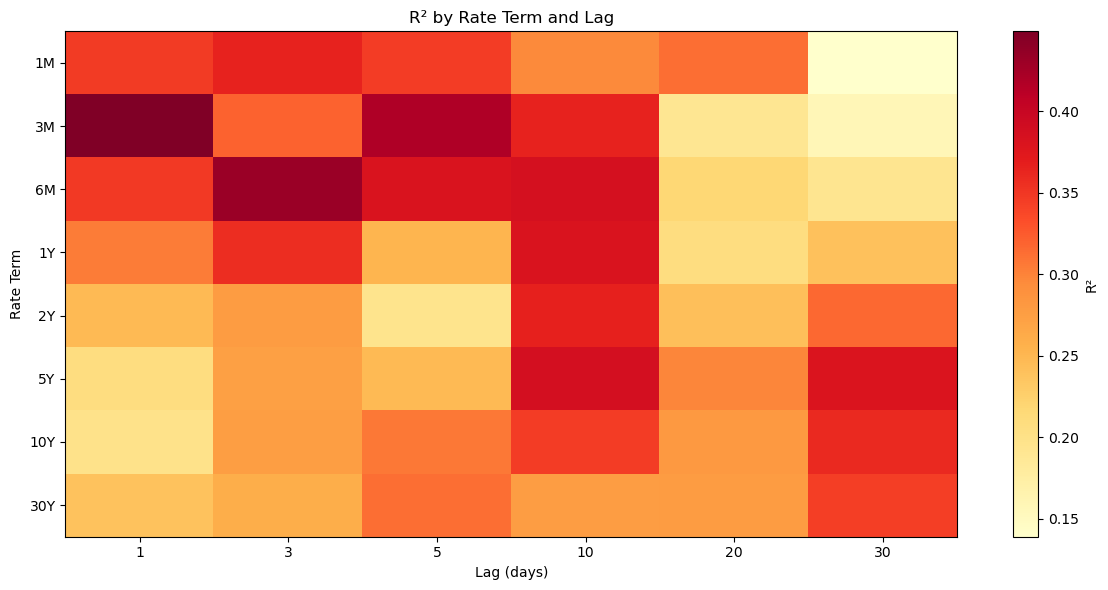

In [90]:
# Plot R² by term and lag
plt.figure(figsize=(12, 6))
terms = ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '30Y']
lags = [1, 3, 5, 10, 20, 30]

r2_matrix = np.zeros((len(terms), len(lags)))
for i, term in enumerate(terms):
    for j, lag in enumerate(lags):
        col = f"{term}_{lag}d"
        if col in results:
            r2_matrix[i, j] = results[col]['r2']

plt.imshow(r2_matrix, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='R²')
plt.xticks(range(len(lags)), lags)
plt.yticks(range(len(terms)), terms)
plt.xlabel('Lag (days)')
plt.ylabel('Rate Term')
plt.title('R² by Rate Term and Lag')
plt.tight_layout()
plt.show()

In [91]:
X = sm.add_constant(regression_df[score_diff_cols])
y = regression_df['10Y_30d']
model = sm.OLS(y, X).fit()
print('Regression results for ', '10Y_30d')
print(model.summary())
print(model.params)
print(model.pvalues)
print(model.rsquared)
print('__________________________')

Regression results for  10Y_30d
                            OLS Regression Results                            
Dep. Variable:                10Y_30d   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     1.447
Date:                Fri, 07 Mar 2025   Prob (F-statistic):              0.139
Time:                        13:44:22   Log-Likelihood:                 2.9573
No. Observations:                  76   AIC:                             38.09
Df Residuals:                      54   BIC:                             89.36
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

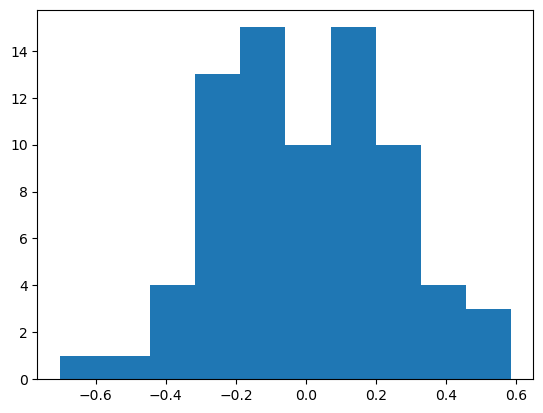

In [88]:
residuals = model.resid
plt.hist(residuals)
plt.show()


In [77]:
target_cols = ['10Y_3d', '10Y_5d', '5Y_3d', '1Y_3d', '2Y_3d', '5Y_3d', '10Y_3d', '30Y_3d']

for col in target_cols:
    X = sm.add_constant(regression_df[score_diff_cols])
    y = regression_df[col]
    model = sm.OLS(y, X).fit()
    print('Regression results for ', col)
    print(model.summary())
    print(model.params)
    print(model.pvalues)
    print(model.rsquared)
    print('__________________________')

Regression results for  10Y_3d
                            OLS Regression Results                            
Dep. Variable:                 10Y_3d   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     3.799
Date:                Thu, 06 Mar 2025   Prob (F-statistic):            0.00160
Time:                        23:35:46   Log-Likelihood:                 113.82
No. Observations:                  74   AIC:                            -211.6
Df Residuals:                      66   BIC:                            -193.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------